## Game structure

In [1]:
struct SimpleGame
    agents::Array{Int}
    reward_space::Array{Int}
    joint_action_space::Array{Array}
    joint_reward_function::Function
end

## Utilities

##### Utility evaluation

In [2]:
function joint(X::Array)
    return collect(Iterators.product(X...))
end

function override(π, πi, i) # override π[i] = πi
    return [i == j ? πi : πj for (j, πj) in enumerate(π)]
end

function utility(G::SimpleGame, π, i)
    A, R = G.joint_action_space, G.joint_reward_function
    p(a) = prod(πj(aj) for (πj,aj) in zip(π, a))
    return sum(R(a)[i] * p(a) for a in joint(A))
end

utility (generic function with 1 method)

##### Base policy

In [3]:
struct SimpleGamePolicy
    p::Dict

    function SimpleGamePolicy(p::Base.Generator)
        return SimpleGamePolicy(Dict(p))
    end

    function SimpleGamePolicy(d::Dict)
        vs = collect(values(d))
        vs ./= sum(vs) #normalize
        return new(Dict(k => v for (k,v) in zip(keys(d), vs)))
    end

    SimpleGamePolicy(ai) = new(Dict(ai => 1.0))
end

(π::SimpleGamePolicy)() = rand(SetCategorical(collect(keys(π.p)), collect(values(π.p))))
(πi::SimpleGamePolicy)(ai) = get(πi.p, ai, 0.0) # p.getOrDefault(ai, 0.0)

##### Response model

In [4]:
function best_response(G::SimpleGame, π, i)
    U(ai) = utility(G, override(π, SimpleGamePolicy(ai), i), i)
    ai = argmax(U, G.joint_action_space[i])
    return SimpleGamePolicy(ai)
end

best_response (generic function with 1 method)

##### Categorical

In [5]:
using Distributions
using LinearAlgebra

struct SetCategorical{S}
    elements::Vector{S} # Set elements (could be repeated)
    distr::Categorical # Categorical distribution over set elements
    
    function SetCategorical(elements::AbstractVector{S}) where S
        weights = ones(length(elements))
        return new{S}(elements, Categorical(normalize(weights,1)))
    end
        
    function SetCategorical(elements::AbstractVector{S}, weights::AbstractVector{Float64}) where S
        ℓ₁ = norm(weights,1)
        if ℓ₁ < 1e-6 || isinf(ℓ₁)
            return SetCategorical(elements)
        end
        distr = Categorical(normalize(weights,1))
        return new{S}(elements,distr)
    end
end

Distributions.rand(D::SetCategorical) = D.elements[rand(D.distr)]
Distributions.rand(D::SetCategorical, n::Int) = D.elements[rand(D.distr, n)]

##### Recorder

In [6]:
mutable struct Record
    agent::Int
    N::Int
    action_count::Dict
    reward_count::Dict

    function Record(G::SimpleGame, index)
        action_space = G.joint_action_space[index]
        reward_space = G.reward_space
        return new(index, 0, Dict(i => 0 for i in action_space), Dict(j => 0 for j in reward_space))
    end
end

function update_record(record::Record, actions::Array, rewards::Array)
    agent = record.agent
    action_count = record.action_count
    reward_count = record.reward_count
    
    action = actions[agent]
    reward = rewards[agent]
    
    record.N += 1
    action_count[action] += 1
    reward_count[reward] += 1
end

update_record (generic function with 1 method)

## Policy

In [7]:
struct Policy
    π
    update::Function
end

(P::Policy)() = P.π()
(P::Policy)(action) = P.π(action)
(P::Policy)(actions::Array) = P.update(P.π, actions) 

##### Fixed policy

In [8]:
function FixedPolicy(d::Dict)
    π = SimpleGamePolicy(d)
    function update_fixed(π, actions) end
    
    return Policy(π, update_fixed)
end

FixedPolicy (generic function with 1 method)

##### Fictitious play policy

In [9]:
mutable struct FictitiousPlay
    G   # game
    i   # agent index
    N   # action count dict
    πi  # policy

    function FictitiousPlay(G::SimpleGame, i)
        N = [Dict(aj => 0 for aj in G.joint_action_space[j]) for j in G.agents]
        πi = SimpleGamePolicy(ai => 1.0 for ai in G.joint_action_space[i])
        return new(G, i, N, πi)
    end
end

(πi::FictitiousPlay)() = πi.πi()
(πi::FictitiousPlay)(ai) = πi.πi(ai)

function update_fictitious(πi::FictitiousPlay, actions)
    N, G, agents, i = πi.N, πi.G, πi.G.agents, πi.i
    
    for (j, aj) in enumerate(actions)
        N[j][aj] += 1
    end

    p(j) = SimpleGamePolicy(aj => u/sum(values(N[j])) for (aj,u) in N[j])
    π = [p(j) for j in agents]
    πi.πi = best_response(G, π, i)
end

function FictitiousPlayPolicy(G::SimpleGame, i)
    π = FictitiousPlay(G, i)
    return Policy(π, update_fictitious)
end

FictitiousPlayPolicy (generic function with 1 method)

## Simulation

In [10]:
function Simulation(G::SimpleGame, P::Array{Policy}, num_round::Int, records::Array{Record})
    @assert(length(P) == length(G.agents))
    agents = G.agents
    get_rewards = G.joint_reward_function

    for i = 1:num_round
        actions = [P[agent]() for agent in agents]
        if i == 1
            println(actions)
        end

        rewards = get_rewards(actions)
        
        for record in records
            update_record(record, actions, rewards)
        end

        for agent in agents
            P[agent](actions)
        end
    end
end

Simulation (generic function with 1 method)

## Rock paper scissors

In [11]:
RPS_NUM_ROUNDS = 1000000

1000000

##### Problem statement

In [12]:
function is_win_over(a1::Symbol, a2::Symbol)
    r = false

    if a1 == :rock && a2 == :scissors
        r = true

    elseif a1 == :scissors && a2 == :paper
        r = true

    elseif a1 == :paper && a2 == :rock
        r = true
    end

    return r
end

function get_reward_rps(a)
    @assert(length(a) == 2)
    r = [-1, 1] # lose

    if a[1] == a[2] # draw
        r = [0, 0]

    elseif is_win_over(a[1], a[2]) # win
        r = [1, -1]
    end

    return r
end

function RockPaperScissors()
    NUM_AGENTS = 2
    ACTIONS = [:rock, :paper, :scissors]
    REWARDS = [-1, 0, 1]

    return SimpleGame(
        collect(1:NUM_AGENTS), # [1, 2]
        REWARDS,
        [ACTIONS for _ in 1:NUM_AGENTS], # [[:rock, :paper, :scissors], [:rock, :paper, :scissors]]
        (a) -> get_reward_rps(a) # [action1, action2] -> [int, int]
    )
end

rps_game = RockPaperScissors()

SimpleGame([1, 2], [-1, 0, 1], Array[[:rock, :paper, :scissors], [:rock, :paper, :scissors]], var"#32#34"())

##### Scenario 1 (Fictitious vs Fictitious #1)

In [13]:
policy_1 = [FictitiousPlayPolicy(rps_game, 1), FictitiousPlayPolicy(rps_game, 2)]
record_1 = [Record(rps_game, 1), Record(rps_game, 2)]
Simulation(rps_game, policy_1, RPS_NUM_ROUNDS, record_1)
record_1

[:paper, :rock]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 333434, :rock => 333688, :paper => 332878), Dict(0 => 0, -1 => 499766, 1 => 500234))
 Record(2, 1000000, Dict(:scissors => 333283, :rock => 332607, :paper => 334110), Dict(0 => 0, -1 => 500234, 1 => 499766))

##### Scenario 2 (Fictitious vs Fictitious #2)

In [14]:
policy_2 = [FictitiousPlayPolicy(rps_game, 1), FictitiousPlayPolicy(rps_game, 2)]
record_2 = [Record(rps_game, 1), Record(rps_game, 2)]
Simulation(rps_game, policy_2, RPS_NUM_ROUNDS, record_2)
record_2

[:scissors, :scissors]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 333083, :rock => 333482, :paper => 333435), Dict(0 => 1000000, -1 => 0, 1 => 0))
 Record(2, 1000000, Dict(:scissors => 333083, :rock => 333482, :paper => 333435), Dict(0 => 1000000, -1 => 0, 1 => 0))

##### Scenario 3 (Fictitious vs Always Rock)

In [15]:
d_3 = Dict(:rock => 1.0, :paper => 0.0, :scissors => 0.0)
policy_3 = [FictitiousPlayPolicy(rps_game, 1), FixedPolicy(d_3)]
record_3 = [Record(rps_game, 1), Record(rps_game, 2)]

Simulation(rps_game, policy_3, RPS_NUM_ROUNDS, record_3)
record_3

[:rock, :rock]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 0, :rock => 1, :paper => 999999), Dict(0 => 1, -1 => 0, 1 => 999999))
 Record(2, 1000000, Dict(:scissors => 0, :rock => 1000000, :paper => 0), Dict(0 => 1, -1 => 999999, 1 => 0))

##### Scenario 4 (Fictitious vs Never Rock)

In [16]:
d_4 = Dict(:rock => 0.0, :paper => 0.5, :scissors => 0.5)
policy_4 = [FictitiousPlayPolicy(rps_game, 1), FixedPolicy(d_4)]
record_4 = [Record(rps_game, 1), Record(rps_game, 2)]

Simulation(rps_game, policy_4, RPS_NUM_ROUNDS, record_4)
record_4

[:rock, :paper]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 999999, :rock => 1, :paper => 0), Dict(0 => 500075, -1 => 1, 1 => 499924))
 Record(2, 1000000, Dict(:scissors => 500075, :rock => 0, :paper => 499925), Dict(0 => 500075, -1 => 499924, 1 => 1))

##### Scenario 5 (Fictitious vs Nearly Random)

In [17]:
d_5 = Dict(:rock => 0.4, :paper => 0.3, :scissors => 0.3)
policy_5 = [FictitiousPlayPolicy(rps_game, 1), FixedPolicy(d_5)]
record_5 = [Record(rps_game, 1), Record(rps_game, 2)]

Simulation(rps_game, policy_5, RPS_NUM_ROUNDS, record_5)
record_5

[:paper, :scissors]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 122, :rock => 19, :paper => 999859), Dict(0 => 299762, -1 => 300195, 1 => 400043))
 Record(2, 1000000, Dict(:scissors => 300180, :rock => 400042, :paper => 299778), Dict(0 => 299762, -1 => 400043, 1 => 300195))

##### Scenario 6 (Fictitious vs Truely Random)

In [18]:
d_6 = Dict(:rock => 1.0, :paper => 1.0, :scissors => 1.0)
policy_6 = [FictitiousPlayPolicy(rps_game, 1), FixedPolicy(d_6)]
record_6 = [Record(rps_game, 1), Record(rps_game, 2)]

Simulation(rps_game, policy_6, RPS_NUM_ROUNDS, record_6)
record_6

[:scissors, :rock]


2-element Vector{Record}:
 Record(1, 1000000, Dict(:scissors => 200579, :rock => 681952, :paper => 117469), Dict(0 => 332883, -1 => 333670, 1 => 333447))
 Record(2, 1000000, Dict(:scissors => 333838, :rock => 332942, :paper => 333220), Dict(0 => 332883, -1 => 333447, 1 => 333670))

## Traveler's dilenma

In [19]:
using Plots
TRAVELER_ROUNDS = 1000

function print_avg(d::Dict)
    sum = 0
    for (k, v) in d
        sum += k * v
    end
    print("Average: ")
    println(sum / TRAVELER_ROUNDS)
end

function generate_gaussian(mean::Float64, var::Float64)
    g(x) = 1 / sqrt(2 * var * pi) * exp(-(x - mean) ^ 2 / (2 * var))
    return Dict(i => g(i) for i in 2:100)
end

generate_gaussian (generic function with 1 method)

##### Problem statement

In [20]:
function get_reward_travelers(a)
    @assert(length(a) == 2)
    r_min = min(a[1], a[2])
    r = [r_min, r_min]

    if a[1] > a[2]
        r[1] -= 2
        r[2] += 2

    elseif a[1] < a[2]
        r[1] += 2
        r[2] -= 2
    end

    return r
end

function TravelersDilenma()
    NUM_AGENTS = 2
    ACTIONS = collect(2:100)
    REWARDS = collect(0:101)

    return SimpleGame(
        collect(1:NUM_AGENTS),
        REWARDS,
        [ACTIONS for _ in 1:NUM_AGENTS],
        (a) -> get_reward_travelers(a)
    )
end

traveler_game = TravelersDilenma()

SimpleGame([1, 2], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  92, 93, 94, 95, 96, 97, 98, 99, 100, 101], Array[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]], var"#39#41"())

##### Scenario 1 (Fictitious vs Fictitious #1)

In [21]:
policy_7 = [FictitiousPlayPolicy(traveler_game, 1), FictitiousPlayPolicy(traveler_game, 2)]
record_7 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_7, TRAVELER_ROUNDS, record_7)

[24, 38]


Average: 28.024


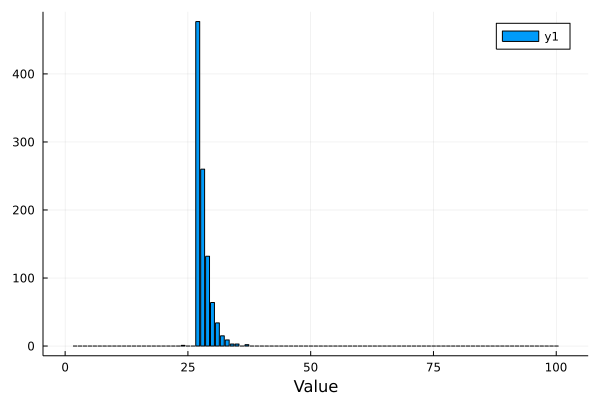

In [22]:
x_71 = collect(keys(record_7[1].action_count))
y_71 = collect(values(record_7[1].action_count))
print_avg(record_7[1].reward_count)
bar(x_71, y_71)
xlabel!("Value")

Average: 28.024


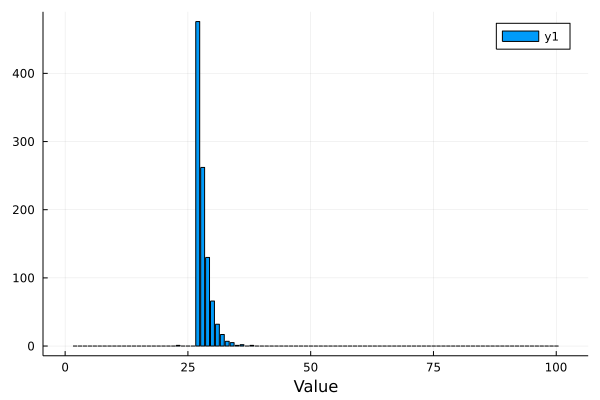

In [23]:
x_72 = collect(keys(record_7[2].action_count))
y_72 = collect(values(record_7[2].action_count))
print_avg(record_7[2].reward_count)
bar(x_72, y_72)
xlabel!("Value")

##### Scenario 2 (Fictitious vs Fictitious #2)

In [24]:
policy_8 = [FictitiousPlayPolicy(traveler_game, 1), FictitiousPlayPolicy(traveler_game, 2)]
record_8 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_8, TRAVELER_ROUNDS, record_8)

[60, 75]


Average: 65.026


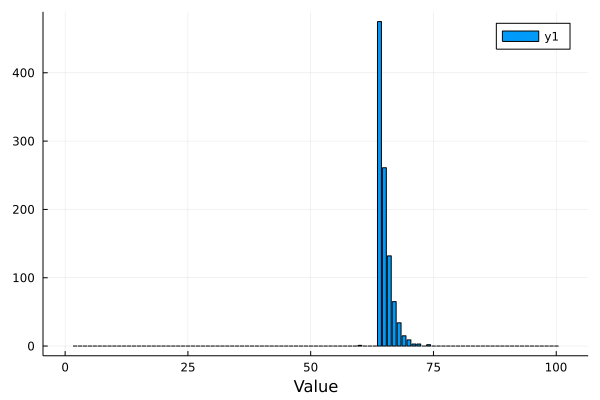

In [25]:
x_81 = collect(keys(record_8[1].action_count))
y_81 = collect(values(record_8[1].action_count))
print_avg(record_8[1].reward_count)
bar(x_81, y_81)
xlabel!("Value")

Average: 65.026


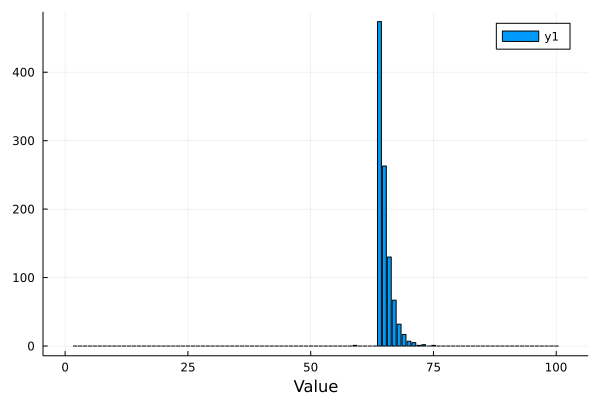

In [26]:
x_82 = collect(keys(record_8[2].action_count))
y_82 = collect(values(record_8[2].action_count))
print_avg(record_8[2].reward_count)
bar(x_82, y_82)
xlabel!("Value")

##### Scenario 3 (Fictitious vs High)

In [39]:
d_9 = generate_gaussian(95.0, 5.0)
policy_9 = [FictitiousPlayPolicy(traveler_game, 1), FixedPolicy(d_9)]
record_9 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_9, TRAVELER_ROUNDS, record_9)

[7, 96]


Average: 94.167


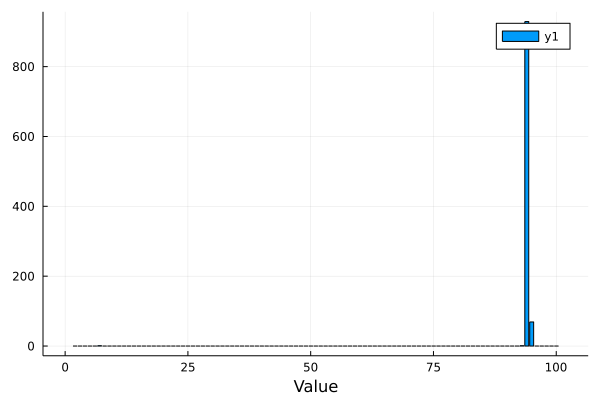

In [40]:
x_91 = collect(keys(record_9[1].action_count))
y_91 = collect(values(record_9[1].action_count))
print_avg(record_9[1].reward_count)
bar(x_91, y_91)
xlabel!("Value")

Average: 92.815


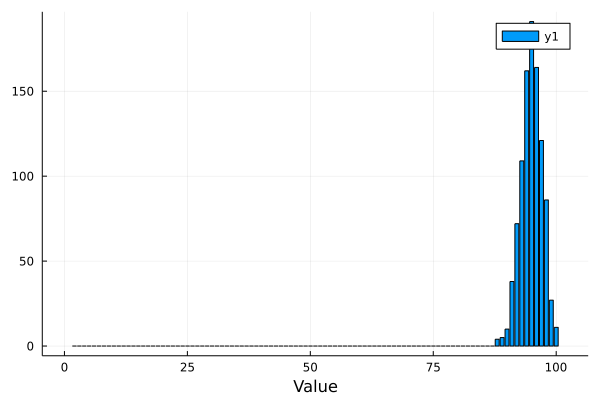

In [41]:
x_92 = collect(keys(record_9[2].action_count))
y_92 = collect(values(record_9[2].action_count))
print_avg(record_9[2].reward_count)
bar(x_92, y_92)
xlabel!("Value")

##### Scenario 4 (Fictitious vs Low)

In [42]:
d_10 = generate_gaussian(7.0, 5.0)
policy_10 = [FictitiousPlayPolicy(traveler_game, 1), FixedPolicy(d_10)]
record_10 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_10, TRAVELER_ROUNDS, record_10)

[41, 3]


Average: 6.186


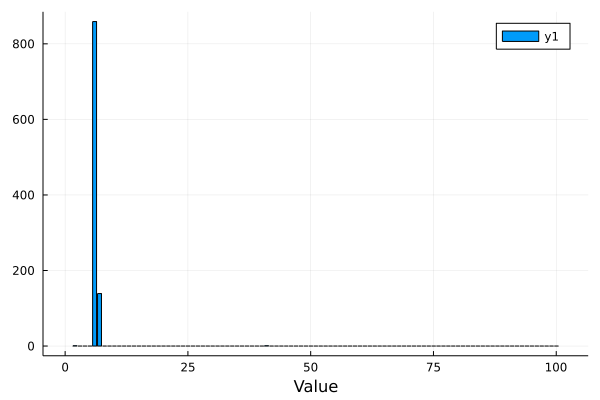

In [43]:
x_101 = collect(keys(record_10[1].action_count))
y_101 = collect(values(record_10[1].action_count))
print_avg(record_10[1].reward_count)
bar(x_101, y_101)
xlabel!("Value")

Average: 5.046


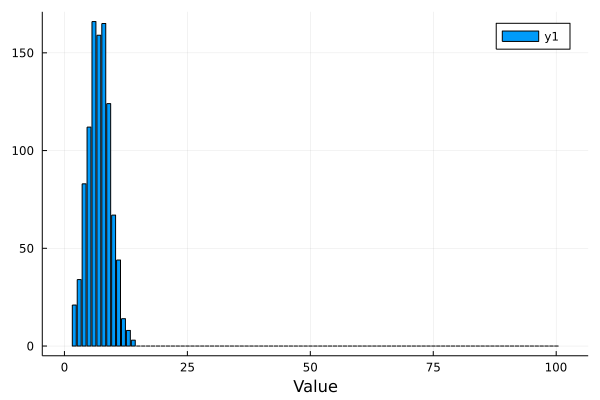

In [44]:
x_102 = collect(keys(record_10[2].action_count))
y_102 = collect(values(record_10[2].action_count))
print_avg(record_10[2].reward_count)
bar(x_102, y_102)
xlabel!("Value")

##### Scenario 5 (Fictitious vs Random)

In [33]:
d_11 = Dict(i => 1.0 for i in collect(2:100))
policy_11 = [FictitiousPlayPolicy(traveler_game, 1), FixedPolicy(d_11)]
record_11 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_11, TRAVELER_ROUNDS, record_11)

[31, 90]


Average: 47.983


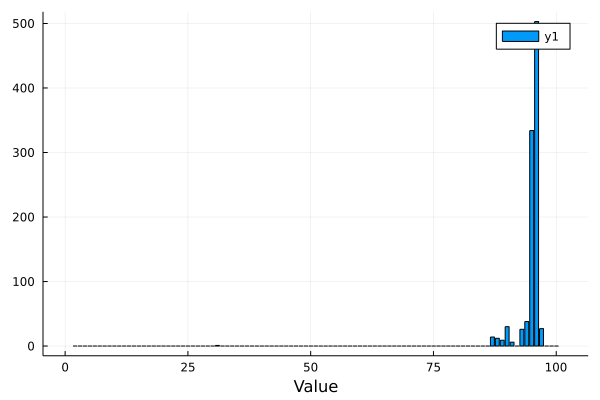

In [34]:
x_111 = collect(keys(record_11[1].action_count))
y_111 = collect(values(record_11[1].action_count))
print_avg(record_11[1].reward_count)
bar(x_111, y_111)
xlabel!("Value")

Average: 51.647


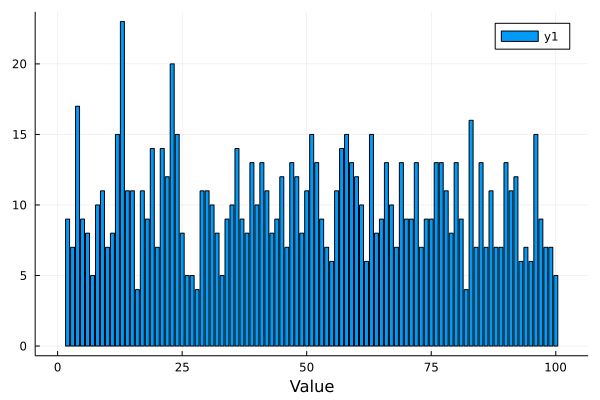

In [35]:
x_112 = collect(keys(record_11[2].action_count))
y_112 = collect(values(record_11[2].action_count))
print_avg(record_11[2].reward_count)
bar(x_112, y_112)
xlabel!("Value")

##### Scenario 6 (Fictitious vs All 2s)

In [36]:
d_12 = Dict(2 => 1.0)
policy_12 = [FictitiousPlayPolicy(traveler_game, 1), FixedPolicy(d_12)]
record_12 = [Record(traveler_game, 1), Record(traveler_game, 2)]
Simulation(traveler_game, policy_12, TRAVELER_ROUNDS, record_12)

[11, 2]


Average: 1.998


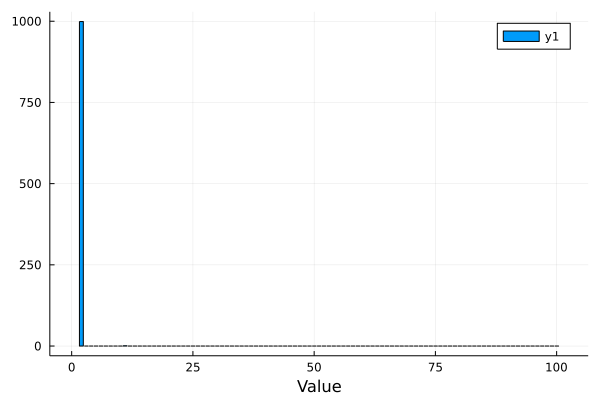

In [37]:
x_121 = collect(keys(record_12[1].action_count))
y_121 = collect(values(record_12[1].action_count))
print_avg(record_12[1].reward_count)
bar(x_121, y_121)
xlabel!("Value")

Average: 2.002


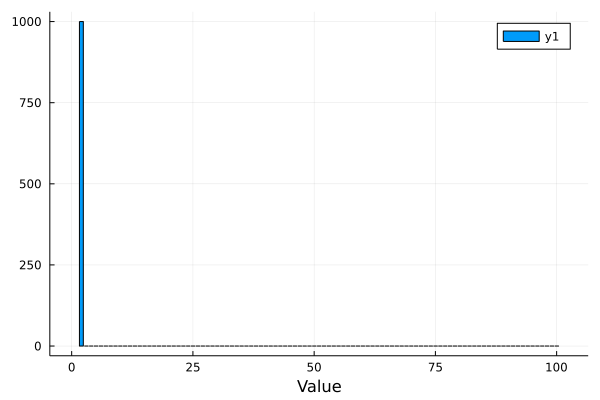

In [38]:
x_122 = collect(keys(record_12[2].action_count))
y_122 = collect(values(record_12[2].action_count))
print_avg(record_12[2].reward_count)
bar(x_122, y_122)
xlabel!("Value")